In [1]:
import scipy.integrate as intg
import scipy.interpolate as inp
from scipy.misc import derivative

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyval

In [2]:
import math
from CoolProp.CoolProp import PropsSI

# test content

## **function for conversion**

In [3]:
def molal_to_massfr(m):
    M_mgcl2 = 95.211    
    x = m*M_mgcl2/1000 / (m*M_mgcl2/1000 + 1 )
    return x

In [4]:
def massfr_to_molal(x):
    M_mgcl2 = 95.211
    m = x/(95.211/1000) / (1-x)
    return m

In [5]:
# relative mean square root error
def RMSRE(ref, sim):
    ref, sim = np.array(ref), np.array(sim)
    result = np.sqrt((((ref - sim)/ref) ** 2).mean())
    return result

## **thermodynamics**

### C_p

In [21]:
# model for calculation heat capacity of water
para_wa = [88.7891, -120.1958, -16.9264, 52.4654, 0.10826, 0.46988]
cp_w = lambda theta: para_wa[0] + para_wa[1]*theta**0.02 + para_wa[2]*theta**0.04 + para_wa[3]*theta**0.06 + para_wa[4]*theta**1.8 + para_wa[5]*theta**8

In [22]:
cp_w(293.15/228-1)

4.146046429834737

In [23]:
cp_w_prop = lambda T: PropsSI('C', 'T', T, 'Q',0, 'IF97::Water')

In [24]:
PropsSI('C', 'T', 293.15, 'Q',0, 'IF97::Water')

4185.102490826854

In [25]:
# correlation
cp_rel = lambda T,x: math.exp(1.148*x)+(-7.316-0.005528*T+T**0.3264)*x

In [26]:
cp = lambda T,x: cp_rel(T, x)*cp_w(theta=T/228-1)

#### short test

In [55]:
T_test = np.linspace(273.16, 333.16, 50)

In [56]:
cp_test = [cp_rel(T_i, 0.3) for T_i in T_test]

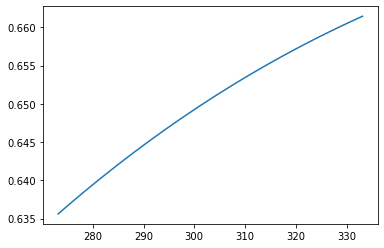

In [57]:
plt.plot(T_test, cp_test)

In [58]:
cp_prop = lambda T,x: cp_rel(T, x)*cp_w_prop(T)/1000

### reference enthalpy @ 25°C

In [9]:
para_ramh_used = [8.3642, -6.8325, 4.2148, -0.56344]

In [10]:
ramh = lambda m: para_ramh_used[0]*m**0.5 + para_ramh_used[1]*m**1 + para_ramh_used[2]*m**1.5 + para_ramh_used[3]*m**2

In [11]:
rel_h = lambda m: ramh(m)*m # unit kJ/kg_water

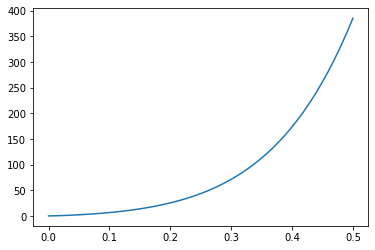

In [12]:
x_test = np.linspace(0, 0.5, num = 50, endpoint = True)
rel_h_test = [rel_h(massfr_to_molal(i)) for i in x_test]
plt.plot(x_test, rel_h_test)

In [13]:
delta_solution_unlimited = -150.82
# refer to Jahn and Wolf 1993
# NBS 159.83
# Shin and Criss 155.82

In [14]:
h_water = lambda T: PropsSI('H','T',T,'Q',0, 'IF97::Water')/1000 #kJ/kg

In [15]:
h_0_ref_25 = lambda m: delta_solution_unlimited * m + h_water(298.15) # kJ/kg_h2o ... input mol/kg

In [16]:
h_at_25_mol = lambda m: (h_0_ref_25(m) + rel_h(m))/(1+0.095211*m) # unit kJ/kg # # kJ/kg_mgcl2_aq ... input mol/kg

In [17]:
h_at_25_mass_frac = lambda x: h_at_25_mol(massfr_to_molal(x)) # unit kJ/kg

In [18]:
h_at_25_mass_frac(0.3)

-351.9654695964666

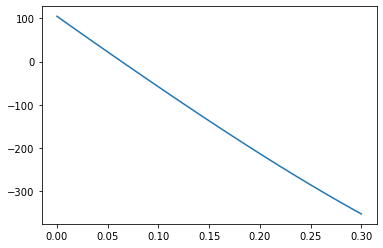

In [19]:
x_test = np.linspace(0, 0.3, num = 50, endpoint = True)
h_at_25_test = [h_at_25_mass_frac(i) for i in x_test]
plt.plot(x_test, h_at_25_test)

### **h** (calculated with cp and h_25)

In [6]:
# simplified calculation of h: integration of Cp(T)dT
# function to get h from T and x  (enthalpy of dilution excluded...)
def get_h(xi, T_1, T_2):
    cp_T_ = lambda T: cp(T=T, x=xi)
    h = intg.quad(cp_T_, T_1, T_2)
    return h

In [7]:
def get_h_with_cp_and_ref_25(T, x):
    h_ref_25 = h_at_25_mass_frac(x)
    intgral_cp = get_h(xi = x, T_1=298.15, T_2=T)[0]
    h = h_ref_25 + intgral_cp
    return h

In [27]:
get_h_with_cp_and_ref_25(313.15, 0)/4.184

39.89992822410549

#### short test

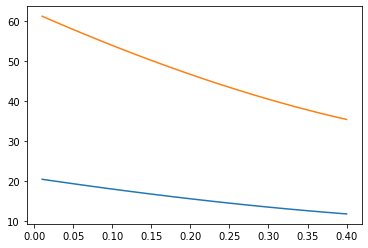

In [28]:
x_test = np.linspace(0.01, 0.4, 40)
h_test = [get_h(xi=xi, T_1 = 298.15, T_2 = 303.15)[0] for xi in x_test]
h_test1 = [get_h(xi=xi, T_1 = 298.15, T_2 = 313.15)[0] for xi in x_test]
plt.plot(x_test, h_test, x_test, h_test1)

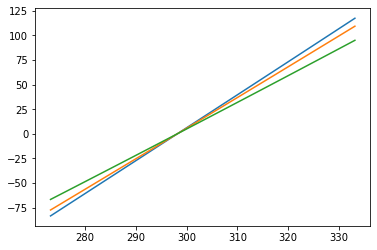

In [29]:
T_test = np.linspace(273.16, 333.16, 60)
h_test_0 = [get_h(xi=0.15, T_1 = 298.15, T_2 = Ti)[0] for Ti in T_test]
h_test_1 = [get_h(xi=0.2, T_1 = 298.15, T_2 = Ti)[0] for Ti in T_test]
h_test_2 = [get_h(xi=0.3, T_1 = 298.15, T_2 = Ti)[0] for Ti in T_test]
plt.plot(T_test, h_test_0, T_test, h_test_1, T_test, h_test_2)

## **Validation**

### validation cp

In [31]:
# reference data of cp from literature
df_ref = pd.read_excel("../table/3_cp.xlsx", sheet_name="3")

In [157]:
# plot for validation
x_solution = np.linspace(0.02, 0.36, 18)

# y_00 = [cp_prop(273.15, i) for i in x_solution]
y_10 = [cp(283.15, i) for i in x_solution]
y_20 = [cp(293.15, i) for i in x_solution]
y_30 = [cp(303.15, i) for i in x_solution]
y_40 = [cp(313.15, i) for i in x_solution]
y_50 = [cp(323.15, i) for i in x_solution]
y_60 = [cp(333.15, i) for i in x_solution]

# df_ref['00_sim'] = y_00
df_ref['10_sim'] = y_10
df_ref['20_sim'] = y_20
df_ref['30_sim'] = y_30
df_ref['40_sim'] = y_40
df_ref['50_sim'] = y_50
df_ref['60_sim'] = y_60

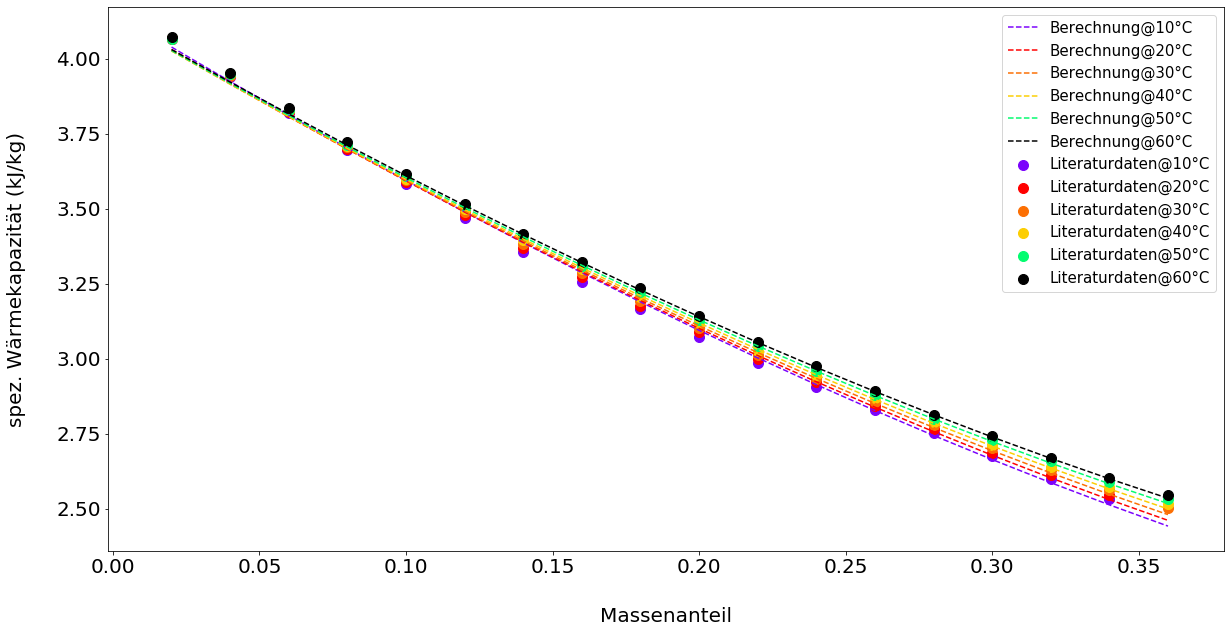

In [84]:
fig, ax = plt.subplots(figsize=(20,10))

# ax.scatter(x_solution, df_ref[0]/1000, label = "Literaturdaten@0°C", marker = "o", s = 100, color = "#0f03fc")
# ax.plot(x_solution, df_ref['00_sim'], label = "Berechnung@0°C", color = "#0f03fc", linestyle='dashed')

ax.scatter(x_solution, df_ref[10]/1000, label = "Literaturdaten@10°C", marker = "o", s = 100,  color = "#7b03fc")
ax.plot(x_solution, df_ref['10_sim'], label = "Berechnung@10°C", color = "#7b03fc", linestyle='dashed')

ax.scatter(x_solution, df_ref[20]/1000, label = "Literaturdaten@20°C", marker = "o", s = 100,  color = "red")
ax.plot(x_solution, df_ref['20_sim'], label = "Berechnung@20°C", color = "red", linestyle='dashed')

ax.scatter(x_solution, df_ref[30]/1000, label = "Literaturdaten@30°C", marker = "o", s = 100,  color = "#fc6f03")
ax.plot(x_solution, df_ref['30_sim'], label = "Berechnung@30°C", color = "#fc6f03", linestyle='dashed')

ax.scatter(x_solution, df_ref[40]/1000, label = "Literaturdaten@40°C", marker = "o", s = 100,  color = "#fcce03")
ax.plot(x_solution, df_ref['40_sim'], label = "Berechnung@40°C", color = "#fcce03", linestyle='dashed')

ax.scatter(x_solution, df_ref[50]/1000, label = "Literaturdaten@50°C", marker = "o", s = 100,  color = "#03fc6f")
ax.plot(x_solution, df_ref['50_sim'], label = "Berechnung@50°C", color = "#03fc6f", linestyle='dashed')

ax.scatter(x_solution, df_ref[60]/1000, label = "Literaturdaten@60°C", marker = "o", s = 100,  color = "black")
ax.plot(x_solution, df_ref['60_sim'], label = "Berechnung@60°C", color = "black", linestyle='dashed')

ax.set_xlabel("Massenanteil", size = 20, labelpad = 30)
ax.set_ylabel("spez. Wärmekapazität (kJ/kg)", size = 20, labelpad = 30)

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(fontsize = 15)
ax.tick_params(labelsize = 20)
# plt.savefig('validation_mgcl2_cp.png', dpi=300, transparent=True)

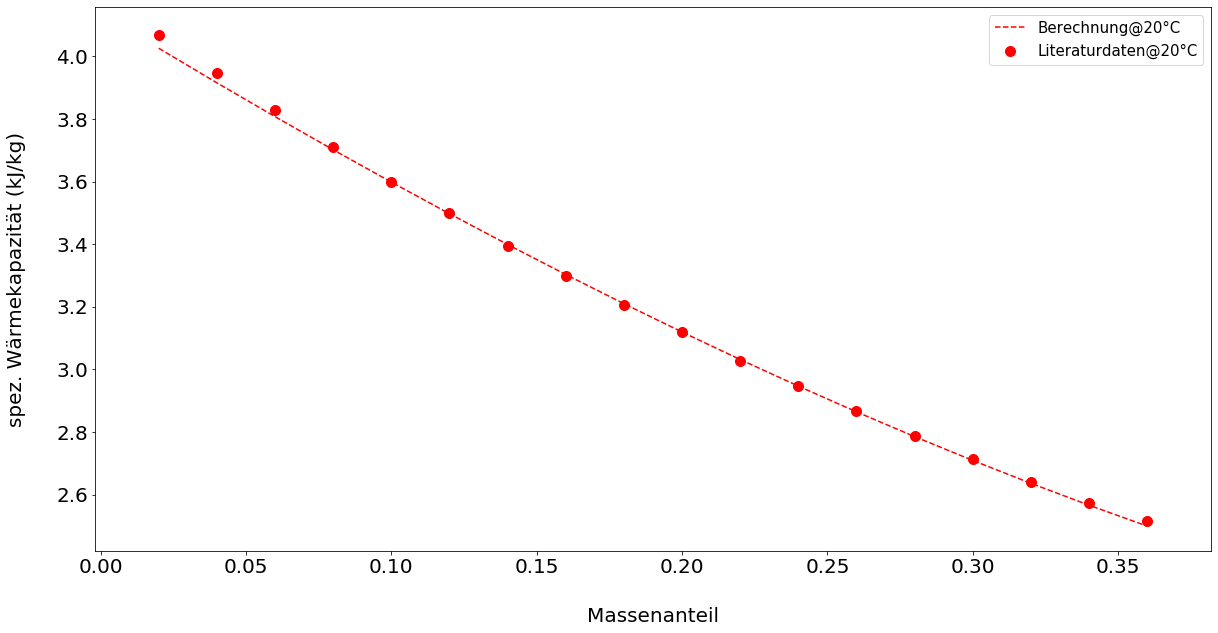

In [85]:
fig, ax = plt.subplots(figsize=(20,10))

# ax.scatter(x_solution, df_ref[0]/1000, label = "Literaturdaten@0°C", marker = "o", s = 100, color = "#0f03fc")
# ax.plot(x_solution, df_ref['00_sim'], label = "Berechnung@0°C", color = "#0f03fc", linestyle='dashed')

# ax.scatter(x_solution, df_ref[10]/1000, label = "Literaturdaten@10°C", marker = "o", s = 100,  color = "#7b03fc")
# ax.plot(x_solution, df_ref['10_sim'], label = "Berechnung@10°C", color = "#7b03fc", linestyle='dashed')

ax.scatter(x_solution, df_ref[40]/1000, label = "Literaturdaten@20°C", marker = "o", s = 100,  color = "red")
ax.plot(x_solution, df_ref['40_sim'], label = "Berechnung@20°C", color = "red", linestyle='dashed')

# ax.scatter(x_solution, df_ref[30]/1000, label = "Literaturdaten@30°C", marker = "o", s = 100,  color = "#fc6f03")
# ax.plot(x_solution, df_ref['30_sim'], label = "Berechnung@30°C", color = "#fc6f03", linestyle='dashed')

# ax.scatter(x_solution, df_ref[40]/1000, label = "Literaturdaten@40°C", marker = "o", s = 100,  color = "#fcce03")
# ax.plot(x_solution, df_ref['40_sim'], label = "Berechnung@40°C", color = "#fcce03", linestyle='dashed')

# ax.scatter(x_solution, df_ref[50]/1000, label = "Literaturdaten@50°C", marker = "o", s = 100,  color = "#03fc6f")
# ax.plot(x_solution, df_ref['50_sim'], label = "Berechnung@50°C", color = "#03fc6f", linestyle='dashed')

# ax.scatter(x_solution, df_ref[60]/1000, label = "Literaturdaten@60°C", marker = "o", s = 100,  color = "black")
# ax.plot(x_solution, df_ref['60_sim'], label = "Berechnung@60°C", color = "black", linestyle='dashed')

ax.set_xlabel("Massenanteil", size = 20, labelpad = 30)
ax.set_ylabel("spez. Wärmekapazität (kJ/kg)", size = 20, labelpad = 30)

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(fontsize = 15)
ax.tick_params(labelsize = 20)
# plt.savefig('validation_mgcl2_cp.png', dpi=300, transparent=True)

In [86]:
df_ref_reverse = df_ref.drop(columns=["molality"]).set_index("mass fraction").T

In [87]:
RMSRE(ref=df_ref_reverse.head(7).tail(6)[0.3]/1000, sim=df_ref_reverse.tail(7).tail(6)[0.3])

0.0026989656057747704

In [88]:
df_ref_reverse.head(7)

mass fraction,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.20,0.22,0.24,0.26,0.28,0.30,0.32,0.34,0.36
0,4065.0,3939.0,3814.0,3692.0,3575.0,3462.0,3349.0,3249.0,3152.0,3060.0,2968.0,2893.0,2817.0,2742.0,2658.0,2583.0,2516.0,NaN
10,4065.0,3939.0,3818.0,3696.0,3583.0,3470.0,3357.0,3257.0,3165.0,3073.0,2985.0,2905.0,2830.0,2754.0,2675.0,2600.0,2533.0,NaN
20,4065.0,3944.0,3822.0,3701.0,3588.0,3479.0,3370.0,3274.0,3177.0,3089.0,3001.0,2922.0,2842.0,2767.0,2687.0,2612.0,2545.0,NaN
30,4065.0,3944.0,3826.0,3705.0,3596.0,3491.0,3382.0,3286.0,3194.0,3102.0,3014.0,2934.0,2855.0,2780.0,2704.0,2629.0,2562.0,2503.0
40,4069.0,3948.0,3830.0,3709.0,3600.0,3500.0,3395.0,3299.0,3207.0,3119.0,3027.0,2947.0,2868.0,2788.0,2713.0,2641.0,2574.0,2516.0
50,4067.0,3948.0,3830.0,3713.0,3609.0,3508.0,3408.0,3311.0,3223.0,3131.0,3043.0,2960.0,2880.0,2801.0,2729.0,2658.0,2591.0,2533.0
60,4073.0,3952.0,3835.0,3722.0,3617.0,3516.0,3416.0,3324.0,3236.0,3144.0,3056.0,2976.0,2893.0,2813.0,2742.0,2671.0,2604.0,2545.0


### validation h

In [32]:
df = pd.read_excel("../table/data from merkel.xlsx", sheet_name="MgCl2")
df.head()

,x00,i00,x20,i20,x40,i40,x60,i60
0,0.000366,0.836361,0.000645,20.501283,0.000094,39.958041,0.000369,59.413762
1,0.001187,0.416921,0.010497,15.886406,0.003385,38.907885,0.003654,57.945204
2,0.003648,-0.841399,0.016249,13.577930,0.005026,38.069005,0.006936,56.267444
3,0.005289,-1.680279,0.019534,12.109372,0.007493,37.229088,0.011045,54.588647
4,0.007757,-2.520196,0.022001,11.269454,0.009958,36.179969,0.015974,52.490409


In [33]:
# transfer columns of dataframe to list
x_60 = df["x60"].dropna().tolist()
y_60 = df["i60"].dropna().tolist()

y_40 = df["i40"].dropna().tolist()
x_40 = df["x40"].dropna().tolist()

y_20 = df["i20"].dropna().tolist()
x_20 = df["x20"].dropna().tolist()

x_00 = df["x00"].dropna().tolist()
y_00 = df["i00"].dropna().tolist()

x_25 = np.linspace(0, 0.6, num = 20, endpoint = True)#x_20
y_25 = [h_at_25_mass_frac(i)/4.184 for i in x_25]

In [34]:
# fit data into polynorm
z_60 = np.polyfit(x_60, y_60, 5, full=True)
z_40 = np.polyfit(x_40, y_40, 5, full=True)
z_20 = np.polyfit(x_20, y_20, 5, full=True)
z_00 = np.polyfit(x_00, y_00, 3, full=True)

In [35]:
# convert polynorm to callable functions
p_60 = np.poly1d(z_60[0])
p_40 = np.poly1d(z_40[0])
p_20 = np.poly1d(z_20[0])
p_00 = np.poly1d(z_00[0])

In [ ]:
# generate a dict for later use
dict_integ_func = {'t20':p_20, 't40':p_40, 't60':p_60, 't0':p_00}

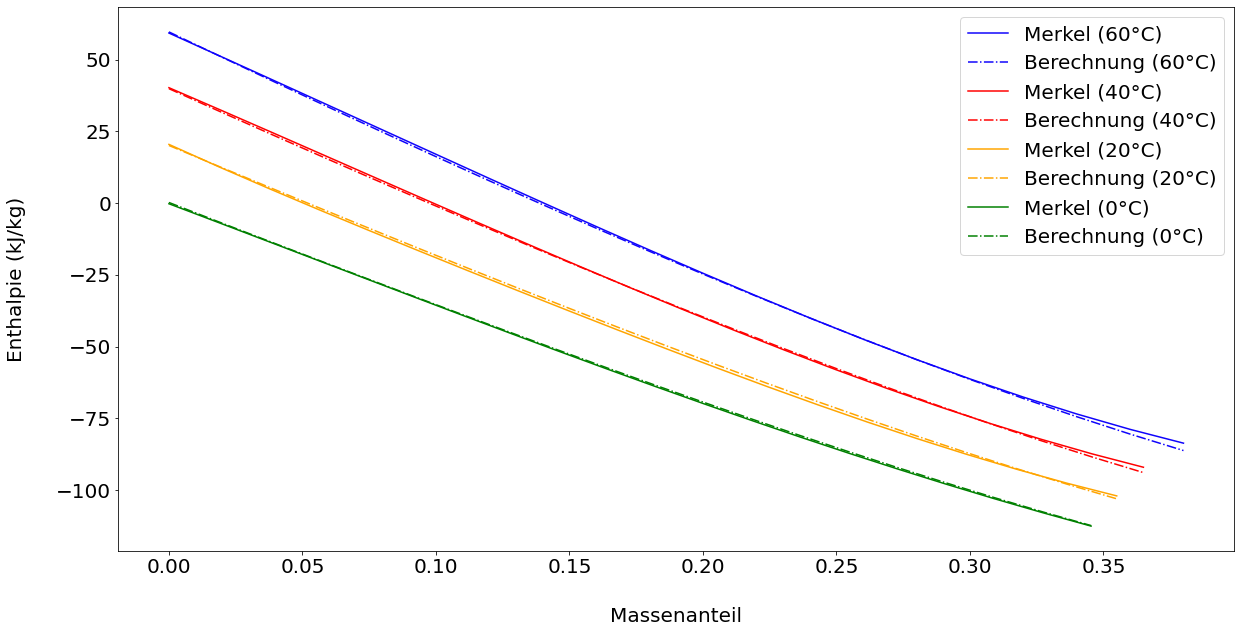

In [42]:
# plot
fig, ax = plt.subplots(figsize=(20,10))

# 60
x_60_new = np.linspace(0, 0.38, num = 20, endpoint = True)
y_60_new = p_60(x_60_new)

y_60_2 = [get_h_with_cp_and_ref_25(333.15, i)/4.184 for i in x_60_new]

# 40
x_40_new = np.linspace(0, 0.365, num = 20, endpoint = True)
y_40_new = p_40(x_40_new)

y_40_2 = [get_h_with_cp_and_ref_25(313.15, i)/4.184 for i in x_40_new]

# 20
x_20_new = np.linspace(0, 0.355, num = 20, endpoint = True)
y_20_new = p_20(x_20_new)

y_20_2 = [get_h_with_cp_and_ref_25(293.15, i)/4.184 for i in x_20_new]

# 0
x_00_new = np.linspace(0, 0.3454, num = 20, endpoint = True)
y_00_new = p_00(x_00_new)

y_00_2 = [get_h_with_cp_and_ref_25(273.15, i)/4.184 for i in x_00_new]


ax.plot(x_60_new, y_60_new, label = "Merkel (60°C)", color = "#0f03fc")
ax.plot(x_60_new, y_60_2, label = "Berechnung (60°C)", color = "#0f03fc", linestyle='-.')

ax.plot(x_40_new, y_40_new, label = "Merkel (40°C)", color = "red")
ax.plot(x_40_new, y_40_2, label = "Berechnung (40°C)", color = "red", linestyle='-.')

ax.plot(x_20_new, y_20_new, label = "Merkel (20°C)", color = "orange")
ax.plot(x_20_new, y_20_2, label = "Berechnung (20°C)", color = "orange", linestyle='-.')

ax.plot(x_00_new, y_00_new, label = "Merkel (0°C)", color = "green")
ax.plot(x_00_new, y_00_2, label = "Berechnung (0°C)", color = "green", linestyle='-.')

ax.tick_params(labelsize = 20)
# plt.plot(x_25, y_25, 'o')
# # plt.plot(x_25, y_25_2, '--') # --> calculation of reference state with considering the molality (always 1 mol/kg_water)
# # plt.plot(x_25, y_25_3, "*")
# # plt.plot(x_25, y_25_new, '*')

plt.legend(fontsize = 20)

ax.set_xlabel("Massenanteil", size = 20, labelpad = 30)
ax.set_ylabel("Enthalpie (kJ/kg)", size = 20, labelpad = 30)

# plt.show()
plt.savefig('validation_mgcl2_h_opaq.png', dpi=300, transparent=False)

#### --test h

In [ ]:
x_20_new = np.linspace(0, 0.355, num = 20, endpoint = True)
y_20_2 = [get_h_with_cp_and_ref_25(293.15, i)/4.184 for i in x_20_new]
y_30_2 = [get_h_with_cp_and_ref_25(303.15, i)/4.184 for i in x_20_new]
y_40_2 = [get_h_with_cp_and_ref_25(313.15, i)/4.184 for i in x_20_new]
plt.plot(x_20_new, y_20_2, x_20_new, y_30_2, x_20_new, y_40_2)

In [ ]:
T_range = np.linspace(273.16, 333.16, 60)
y_x_02 = [get_h_with_cp_and_ref_25(Ti, 0.2)/4.184 for Ti in T_range]
y_x_03 = [get_h_with_cp_and_ref_25(Ti, 0.3)/4.184 for Ti in T_range]
y_x_04 = [get_h_with_cp_and_ref_25(Ti, 0.4)/4.184 for Ti in T_range]
plt.plot(T_range, y_x_02, T_range, y_x_03, T_range, y_x_04)

## convert origin function to multi-variante-polynom --> with scikit-learn

In [ ]:
import pandas as pd

In [ ]:
import itertools as it

In [ ]:
# origin function
get_h_with_cp_and_ref_25(313.15, 0)/4.184

In [ ]:
# prepare T and x in range 
T = np.linspace(273.16, 353.16, 801)
x = np.linspace(0, 0.4, 401)

In [ ]:
# generate matrix
# product computes the Cartesian product
Z = [list(it.product([t],x)) for t in T]

In [ ]:
# store T and x into a dataframe
list_a = []
for i in range(len(Z)):
    list_a.append(pd.DataFrame(Z[i]))
df_T_x = pd.concat(list_a).reset_index().drop(columns = ["index"])
df_T_x = df_T_x.rename(columns={0:"T", 1:"x"})

In [ ]:
# use original function to calculate h as the third column of the dataframe
vfunc = np.vectorize(get_h_with_cp_and_ref_25)
df_T_x['h'] = vfunc(df_T_x['T'], df_T_x['x'])

In [ ]:
df_T_x.head()

In [ ]:
# use as_matrix to convert first two columns of the dataframe to Scikitlearn readable array format
array_T_x = df_T_x.as_matrix(columns=df_T_x.columns[:-1])

In [ ]:
# import relevant libraries of scikitlearn
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn import linear_model

In [ ]:
# polynominate the T and x to (1 + T + x +T² + T*x + x²)
poly = PolynomialFeatures(degree = 2)
array_T_x_poly = poly.fit_transform(array_T_x)

In [ ]:
array_h = df_T_x[['h']].to_numpy()

In [ ]:
# df_T_x['h'].to_numpy() cannot be used: [[]] is needed

In [ ]:
# fit
output_model = linear_model.LinearRegression()
output_model.fit(array_T_x_poly, array_h)

In [ ]:
output_model.coef_

In [ ]:
# DO NOT FORGET INTERCEPT
output_model.intercept_

In [ ]:
# convert to implementable function
output_eq = lambda T,x: 3.75550823e+00 * T + -5.11934879e+02 *x + 4.78672511e-04 * T**2\
+ T*x*-4.44122366e+00 + x**2*8.36881428e+02 -1052.5261563

In [ ]:
# test
get_h_with_cp_and_ref_25(293.16, 0.2)

In [ ]:
output_eq(288.16, 0.4)

In [ ]:
# without intercept
output_model2 = linear_model.LinearRegression(fit_intercept=False)

In [ ]:
output_model2.fit(array_T_x_poly, array_h)

In [ ]:
output_model2.coef_

In [ ]:
output_model2.intercept_